## Context

Two time series with recurring data from FRED (Federal Reserve Economic Data) have been selected. On one hand, we have the variable "date," and on the other, the University of Michigan Consumer Sentiment Index. This index is a measure of consumer confidence in the U.S. economy. It is based on surveys that ask consumers about their current perceptions and attitudes towards personal finances, general economic conditions, and intentions to purchase durable goods. High values indicate a higher level of consumer confidence, which is generally considered positive for consumer spending and, therefore, for the economy.

The third variable will be Industrial Production. This series measures the actual output of all facilities in the U.S. manufacturing sector based on the North American Industry Classification System (NAICS). It is an important indicator of economic health, as it reflects the level of activity in factories, mines, and utilities. An increase in industrial production suggests economic growth, while a decrease may indicate an economic contraction.

The goal is to predict future trends using the information from both graphs.

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd
import pandas_datareader.data as web

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import minmax_scale

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Lambda
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import load_model

import matplotlib.pyplot as plt
import seaborn as sns
import time

In [7]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [8]:
seed=42

sns.set_style('whitegrid')
np.random.seed(seed)
tf.random.set_seed(seed)

In [9]:
results_path = Path('results', 'time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

## 1. Data Loading / Analysis / Preprocessing / Visualization

Throughout the training and evaluation of the models, I have encountered some points that I find interesting regarding the dataset and the approach described in this text. I think it’s worth writing them down and supporting the information with evidence, using different variations of the dataset and strategies for making predictions. I primarily aim to discuss two points:

1. Structure of the Time Series: The time series is defined for the years 1980 to 2023. As seen in the figures displaying the time series, both for the sentiment variable and the ip variable (the latter perhaps being more visibly affected), there are at least two moments when the variable values change drastically. One corresponds to the 2008 financial crisis, and the other to the COVID-19 pandemic in 2020.

We will try to make predictions using data from the last six months for future months close to the year 2020. I believe this impacts the models' ability to predict those months in 2022 and 2023. As we will observe, the loss values for the validation set (val_loss) are consistently higher than those for the training set. The latter is affected by dropout in the recurrent network layers, while the former is not.

When I trained the models for the first time, I found this curious. Upon reviewing the time series, I think the problem may lie in the drastic changes in the series shortly before the values we try to predict—especially for the sentiment variable (which has a major change during COVID-19 and another in 2022), less so for the ip variable. To confirm this, I retrained one of the models (RNNsimple) but using data only up to 2019. I observed that the apparent overfitting issue (which I believe is caused by those drastic changes in the time series, leading to a lack of stable structure between the training and test sets) disappears.

Since addressing the time series structure is not the goal of this text, I won’t delve into this too deeply. However, I find it interesting to note how the models and their generalization capabilities appear to be clearly sensitive to this. To illustrate this point (and although I noticed similar behavior across all models shown here), I will show one example of training and testing with the dataset "trimmed" before 2020 in the RNNsimple network section.

2. Using Two Variables to Train the Model and Predicting Two Variables Simultaneously
The instructions ask us to handle the dataset in a unified way, feeding both variables (sentiment and ip) to the models simultaneously. This means that each instance of input sequences X has a structure of (6,2), and each y instance (i.e., the labels) has a structure of (2).

Initially, I expected that using two variables would be advantageous for the models. However, the results I found with the models required in the instructions are either satisfactory for only one of the two variables or poor for both. Although I’m not entirely certain, I suspect the models may somehow be mixing the information from the two variables. Given that these variables do not fully correlate during the two years we are asked to predict (from May 2022 onward, sentiment tends to increase while ip decreases), the prediction results are generally poor.

To illustrate this point, for the RNNsimple model, I show one version where both variables are trained and predicted simultaneously, along with two additional versions where the models are trained and predictions are made for each variable separately.

In [10]:
# Data loading
df = web.DataReader(['UMCSENT', 'IPGMFN'], 'fred', '1980', '2023-12').dropna()
df.columns = ['sentiment', 'ip']
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 528 entries, 1980-01-01 to 2023-12-01
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sentiment  528 non-null    float64
 1   ip         528 non-null    float64
dtypes: float64(2)
memory usage: 12.4 KB


,sentiment,ip
DATE,,
1980-01-01,67.0,45.8562
1980-02-01,66.9,46.9435
1980-03-01,56.5,47.5013
1980-04-01,52.7,46.1175
1980-05-01,51.7,44.7997


In [11]:
# Check NAs in "sentiment"
df.loc[df["sentiment"].isnull()==True]

,sentiment,ip
DATE,,


In [12]:
# Check NAs in "ip"
df.loc[df["ip"].isnull()==True]

,sentiment,ip
DATE,,


In [13]:
# Set the number of months for which we want to calculate the difference (1 year)
periods = 12

# Get the logarithm of each value and calculate the 12-month difference
df["diff_log_sentiment"] = np.log(df["sentiment"]).diff(periods=periods)
df["diff_log_ip"] = np.log(df["ip"]).diff(periods=periods)

# Min-max scaling
max_sentiment = df["diff_log_sentiment"].max()
min_sentiment = df["diff_log_sentiment"].min()

max_ip = df["diff_log_ip"].max()
min_ip = df["diff_log_ip"].min()

df["min-max_sentiment"] = (df["diff_log_sentiment"] - min_sentiment) / (max_sentiment - min_sentiment)
df["min-max_ip"] = (df["diff_log_ip"] - min_ip) / (max_ip - min_ip)

In [14]:
df.head(24)

,sentiment,ip,diff_log_sentiment,diff_log_ip,min-max_sentiment,min-max_ip
DATE,,,,,,
1980-01-01,67.0,45.8562,NaN,NaN,NaN,NaN
1980-02-01,66.9,46.9435,NaN,NaN,NaN,NaN
1980-03-01,56.5,47.5013,NaN,NaN,NaN,NaN
1980-04-01,52.7,46.1175,NaN,NaN,NaN,NaN
1980-05-01,51.7,44.7997,NaN,NaN,NaN,NaN
1980-06-01,58.7,44.9905,NaN,NaN,NaN,NaN
1980-07-01,62.3,42.0545,NaN,NaN,NaN,NaN
1980-08-01,67.3,43.5527,NaN,NaN,NaN,NaN
1980-09-01,73.7,45.2613,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'min-max scaling')

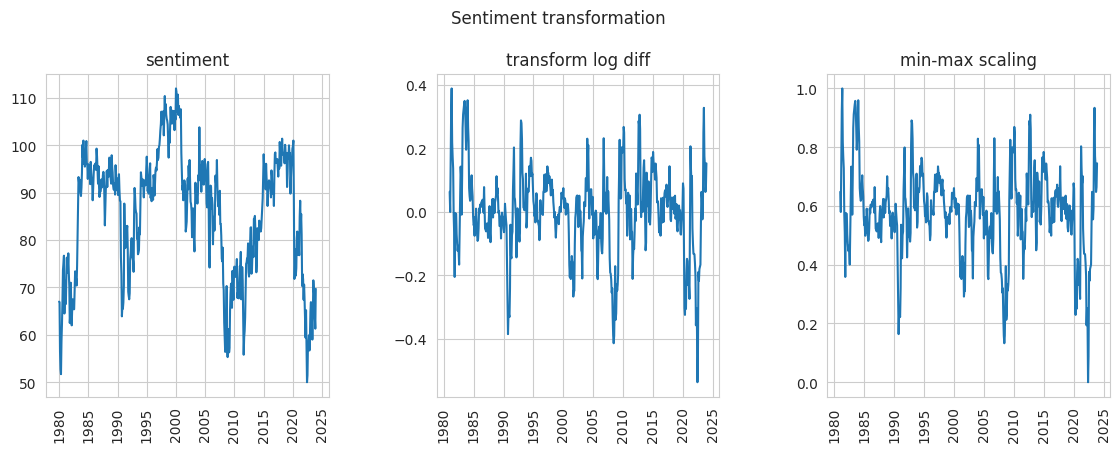

In [15]:
# Show the original "sentiment" time series and its transformations

fig, ax = plt.subplots(1, 3)
fig.suptitle("Sentiment transformation", y=1.05)
fig.tight_layout()
fig.set_size_inches(12, 4)
ax[0].plot(df["sentiment"])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("sentiment")

ax[1].plot(df["diff_log_sentiment"])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("transform log diff")

ax[2].plot(df["min-max_sentiment"])
ax[2].tick_params(axis='x', rotation=90)
ax[2].set_title("min-max scaling")

Text(0.5, 1.0, 'min-max scaling')

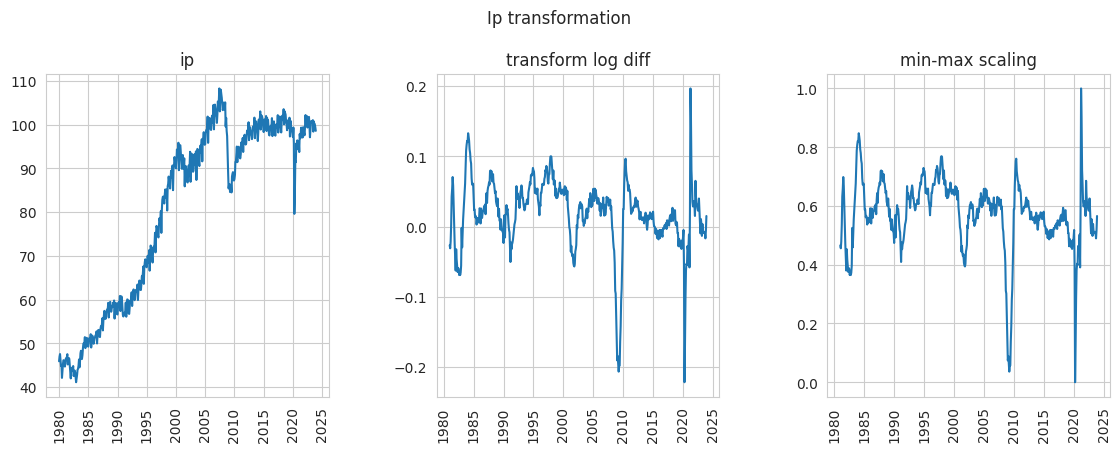

In [16]:
# Show the original "ip" time series and its transformations

fig, ax = plt.subplots(1, 3)
fig.suptitle("Ip transformation", y=1.05)
fig.tight_layout()
fig.set_size_inches(12, 4)
ax[0].plot(df["ip"])
ax[0].tick_params(axis='x', rotation=90)
ax[0].set_title("ip")

ax[1].plot(df["diff_log_ip"])
ax[1].tick_params(axis='x', rotation=90)
ax[1].set_title("transform log diff")

ax[2].plot(df["min-max_ip"])
ax[2].tick_params(axis='x', rotation=90)
ax[2].set_title("min-max scaling")

In [17]:
# Finally, we keep only the transformed data

# Additionally, since the 12-month difference cannot be applied to the first
# 12 rows (as there is no data prior to 1980), these 12 rows are marked as NaN. Therefore, we remove them.

df = df[["min-max_sentiment", "min-max_ip"]].dropna()

In [18]:
# Show the first 13 months of data
df.head(13)

,min-max_sentiment,min-max_ip
DATE,,
1981-01-01,0.648259,0.465891
1981-02-01,0.579549,0.455921
1981-03-01,0.755588,0.478975
1981-04-01,0.922628,0.535938
1981-05-01,1.000000,0.631726
1981-06-01,0.816544,0.658569
1981-07-01,0.766923,0.698415
1981-08-01,0.727802,0.668894
1981-09-01,0.570718,0.599701


## 2. Data Preparation for Multivariable Model
Once we have preprocessed the data, we will prepare it in the specific format required by a recurrent neural network. To do so, I will:

1. Define and apply a function `create_multivariate_rnn_data`> that transforms the dataset df created above into a format suitable for training a recurrent model. The function should take the dataset and the window size (`window_size`) as input and return a data structure containing the input sequences (X) and target labels (y).
  
2. Use a `window_size` of 6 months to create the X and y datasets and verify the dimensions of the resulting datasets to ensure the transformation was performed correctly.

3. Split the transformed data into training and test sets, using the last 24 months of data as the test set. Besides, I will ensure that both the input data (X_train, X_test) and the labels (y_train, y_test) are correctly partitioned.








In [19]:
# We define the function to split the data and generate the input sequences and target labels.
def create_multivariate_rnn_data(df, window_size):
    """
    For two variables (X and y, both as lists) already created, the function takes a dataframe and a window_size as input.

    For the variable X, the function returns sequences of 6 records (dates) and two variables (sentiment and ip).
    For the variable y, the function returns a single record with two variables corresponding to the record immediately following the last record in each sequence of X:
    
    If we have records 0, 1, 2, 3, 4, 5, 6, 7, 8, and 9, the function will return the variables X and y with the following structure:
    [[0,1,2,3,4,5],
     [1,2,3,4,5,6],
     [2,3,4,5,6,7],
     [3,4,5,6,7,8]]
     
    y:
    [[6],
     [7],
     [8],
     [9]] 
    """
    train=[]
    test=[]
    for el in range(len(df)-window_size):
        train.append(np.array(df.iloc[el:el+window_size]))
        test.append(np.array(df.iloc[el+window_size]))
    return train, test

In [20]:
# Establish the desired window size
window_size = 6

# Vars to store sequences and labels
X = []
y = []

# Call the function to extract the data in the desired format
X, y = create_multivariate_rnn_data(df, window_size)

# Convert the lists to arrays to feed the NN
X = np.array(X)
y = np.array(y)

In [21]:
# Separate training and test sets
# The training set includes all labels except the last 24, as well as the sequences (X) needed to predict those labels.

# The test set includes the last 24 labels, as well as the sequences (X) needed to predict those labels.

X_train = X[0:-24]
X_test = X[-24:]

y_train = y[0:-24]
y_test = y[-24:]

In [22]:
# Check that the split is correct

# As a reference, show the values of the source dataframe between record -30 and -20.
df.tail(30).head(10)

,min-max_sentiment,min-max_ip
DATE,,
2021-07-01,0.701973,0.674225
2021-08-01,0.522680,0.613884
2021-09-01,0.472282,0.598145
2021-10-01,0.437186,0.603521
2021-11-01,0.437106,0.616007
2021-12-01,0.435110,0.600742
2022-01-01,0.404791,0.565950
2022-02-01,0.362148,0.685500
2022-03-01,0.193704,0.633995


The record 2022-01-01 0.404791 0.56594984 corresponds to the 24th, starting from the end. Therefore, this should be the first record of `y_test`

In [23]:
# Check the first record of `y_test`
y_test[0]

array([0.40479131, 0.56594984])

Vemos que el valor es correcto. Además, el registro anterior a este (esto es, 2021-12-01 0.435110 0.60074157) debería ser el último registro de la primera secuencia de `X_test`

In [24]:
X_test[0]

array([[0.70197264, 0.67422499],
       [0.52268033, 0.61388372],
       [0.47228165, 0.59814462],
       [0.43718607, 0.60352084],
       [0.43710574, 0.61600703],
       [0.43510989, 0.60074157]])

Again, the value is correct. Let's continue with the verification. The record 2021-12-01 0.435110 0.60074157 corresponds to the 25th, starting from the end. Therefore, this should be the last record of `y_train`

In [25]:
y_train[-1]

array([0.43510989, 0.60074157])

Again, the value is correct. Finally, the previous record (that is, 2021-11-01 0.437106 0.61600703) should be the last record of the last sequence of `X_train`

In [26]:
X_train[-1]

array([[0.6773403 , 0.72158213],
       [0.70197264, 0.67422499],
       [0.52268033, 0.61388372],
       [0.47228165, 0.59814462],
       [0.43718607, 0.60352084],
       [0.43710574, 0.61600703]])

**The values of `X_train`, `X_test`, `y_train`, and `y_test` are correct, and we can continue with the creation of models.**